In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.activations import linear, relu, sigmoid


from keras.datasets import mnist

from my_utils import calculate_metrics

np.set_printoptions(precision = 1)



2024-06-17 16:53:35.623675: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/damanr/Desktop/myprojectA/lib/python3.8/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
print(f'The shape of the training example features (X_train): {X_train.shape}')
print(f'The shape of the training example labels   (y_train): {y_train.shape}', end = '\n\n')

print(f'The shape of the test example features (X_test): {X_test.shape}')
print(f'The shape of the test example labels   (y_test): {y_test.shape}')



The shape of the training example features (X_train): (60000, 28, 28)
The shape of the training example labels   (y_train): (60000,)

The shape of the test example features (X_test): (10000, 28, 28)
The shape of the test example labels   (y_test): (10000,)


In [4]:
# Create a cross validation set from the training data to assist in model architecture selection and hyperparameter tuning
cross_validation_size = 10000

X_cv, y_cv = X_train[len(X_train) - cross_validation_size:] , y_train[len(y_train) - cross_validation_size:]
X_train , y_train = X_train[:len(X_train) - cross_validation_size] , y_train[:len(y_train) - cross_validation_size]

print(f'The shape of the validation set features (X_cv): {X_cv.shape}')
print(f'The shape of the validation set labels   (y_cv): {y_cv.shape}', end = '\n\n')

print(f'New shape of the training example features (X_train): {X_train.shape}')
print(f'New shape of the training example labels   (y_train): {y_train.shape}', end = '\n\n')



The shape of the validation set features (X_cv): (10000, 28, 28)
The shape of the validation set labels   (y_cv): (10000,)

New shape of the training example features (X_train): (50000, 28, 28)
New shape of the training example labels   (y_train): (50000,)



In [5]:
#Visualize data structure
print('First 3 Training Examples',X_train[:3],sep = '\n',end = '\n\n\n')
print('Target Labels',y_train[:3],sep = '\n')

First 3 Training Examples
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


Target Labels
[5 0 4]


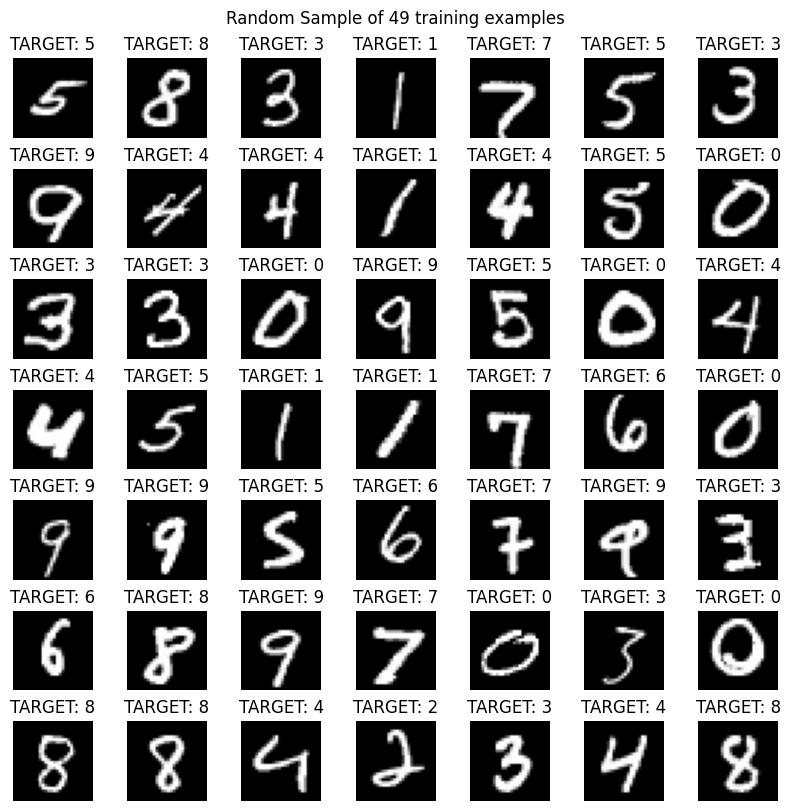

In [6]:
# View a random sampling of data
rows = 7
columns = 7 


random_indices = np.random.choice(a = len(X_train) , size = rows * columns, replace = False)

fig, axes = plt.subplots(rows,columns, constrained_layout = True)

fig.set_size_inches(8,8,forward = True)
fig.set_dpi(100)


train_count = 0
for i in range(7):
    for j in range(7):
        axes[i,j].imshow(X_train[random_indices[train_count]], cmap = 'gray')
        axes[i,j].set_title(f'TARGET: {y_train[random_indices[train_count]]}')
        axes[i,j].axis('off')
        train_count+=1

fig.suptitle(f'Random Sample of {rows * columns} training examples')

plt.show()
        

In [7]:
# Convert 28 x 28 grids of pixes to 1-D array holding sequential pixel intensities
X_train = X_train.reshape(-1,X_train.shape[1] * X_train.shape[2])
X_cv = X_cv.reshape(-1,X_cv.shape[1] * X_cv.shape[2])

X_test = X_test.reshape(-1,X_test.shape[1] * X_test.shape[2])

print(f'Finalized model input feature shape for X_train: {X_train.shape}')
print(f'Finalized model input feature shape for X_cv: {X_cv.shape}')
print(f'Finalized model input feature shape for X_test: {X_test.shape}')

Finalized model input feature shape for X_train: (50000, 784)
Finalized model input feature shape for X_cv: (10000, 784)
Finalized model input feature shape for X_test: (10000, 784)


## Creating Baseline Model 
It may be interesting to create a weak learner model that is essentially logistic regression. 
I will achieve this by creating a basic neural network with NO hidden layers, performing a classic logistic regression problem. 
This will act as a baseline to improve from. 

Performance metrics that will be analyzed:
1. Cost Function (Error Misclassified)
2. F_1 Score
   

In [13]:
baseline_model = Sequential([
    tf.keras.Input(shape = (X_train.shape[1])),
    Dense(units = 10, activation = 'linear', name = 'baseline_output')
], name = 'baseline_model')

In [14]:
baseline_model.summary()

Model: "baseline_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 baseline_output (Dense)     (None, 10)                7850      
                                                                 
Total params: 7850 (30.66 KB)
Trainable params: 7850 (30.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
baseline_model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
)

# batch_size was increase to allow for slightly faster computation speed per epoch
epoch_progress = baseline_model.fit(X_train, y_train, epochs = 100,verbose = 1,batch_size = 360)

Epoch 1/5
21/21 [==============================] - 0s 4ms/step - loss: 159.3736
Epoch 2/5
21/21 [==============================] - 0s 5ms/step - loss: 119.1857
Epoch 3/5
21/21 [==============================] - 0s 5ms/step - loss: 94.3686
Epoch 4/5
21/21 [==============================] - 0s 5ms/step - loss: 76.2756
Epoch 5/5
21/21 [==============================] - 0s 5ms/step - loss: 62.2291


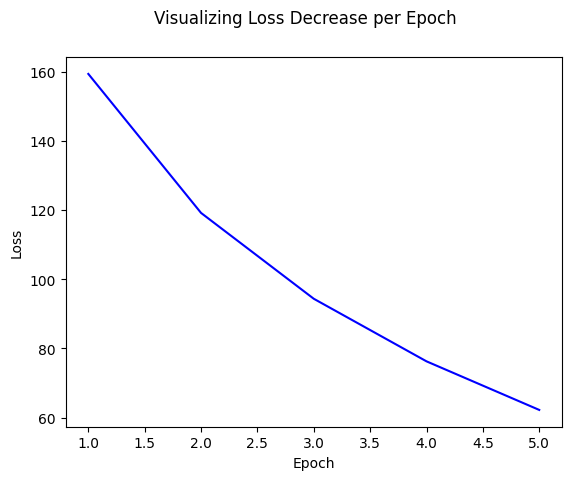

In [16]:
# Plot training curve to ensure accurate decrease of loss per epoch.
# Done to avoid divergence of gradient descent
losses = epoch_progress.history['loss']

plt.close('all')
fig, ax = plt.subplots()

fig.suptitle('Visualizing Loss Decrease per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.plot(range(1,len(losses)+1), losses, color = 'blue')


The Loss curve above shows signs of continuous decrease, confirming that an appropriate learning rate has been choosen for the baseline model.

NOTE: For the baseline model, a manual grid search approach will be carried out to optimize the parameters. For the later models a more efficient library will be used for hyperparameter tuning. 

### Baseline Model Performance
Due to the educational nature of this personal project, the metric calculations will be done by hand to demonstrate understanding of key concepts. 
In practice, a library such as sklearn will be used.

In [17]:
metrics = calculate_metrics(baseline_model, X_cv , y_cv)



313/313 [==============================] - 0s 703us/step
baseline_model's ACCURACY             :0.352

baseline_model's ERROR                :0.648

baseline_model's PRECISION (per class):[0.509, 0.226, 0.472, 0.452, 0.222, 0.326, 0.401, 0.46, 0.262, 0.148]

baseline_model's RECALL (per class):[0.509, 0.226, 0.472, 0.452, 0.222, 0.326, 0.401, 0.46, 0.262, 0.148]

baseline_model's F1 Score (average):0.348


Naturally, the performance of the baseline model is fairly poor. Missclassifying ~ 10% of the cross validation dataset.